In [0]:
################################################################################
# %% CONNECT TO DRIVE
################################################################################

from google.colab import drive, files
drive.mount('/content/drive')

In [0]:
################################################################################
# %% IMPORT PACKAGES
################################################################################

import os
import glob
import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import sys
from time import time
import matplotlib.pyplot as mp
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam

In [0]:
################################################################################
# %% LOAD DATA AND SPLIT INTO BATCHES
################################################################################

def generate_data(dpath, batch_size=128, tag='train'):

    ##### READ FOLDER CONTENTS
    fimg = sorted(glob.glob(dpath+f'image-{tag}*'))
    flbl = fimg
    flbl = [f.replace('image', 'label') for f in flbl] 

    ##### READ FIRST FILE TO BUFFER
    print(f'----> Reading {fimg[0]} <----')
    print(f'----> Reading {flbl[0]} <----')
    X_in = np.load(fimg[0])
    y_in = np.load(flbl[0])

    ##### SHUFFLE
    idx = np.arange(len(X_in))
    idx = np.random.shuffle(idx)

    X_in = X_in[idx][0, :, :, :, :]
    y_in = y_in[idx][0, :, :, :, :]

    ##### START COUNTING
    i = 0
    
    ##### LOOP INDEFINITELY
    while True:

        ##### IF BUFFER NOT SUFFICIENT TO COVER NEXT BATCH
        if len(X_in) < batch_size:

            ##### SET NEXT INDEX BASED ON LENGHT OF FOLDER CONTENTS
            if i<len(fimg)-1:
                i += 1
            else:
                i = 0
            
            ##### APPEND NEXT FILE
            print(f'----> Reading {fimg[i]} <----')
            print(f'----> Reading {flbl[i]} <----')
            X_in = np.concatenate((X_in, np.load(fimg[i])), axis=0)
            y_in = np.concatenate((y_in, np.load(flbl[i])), axis=0)

            ##### SHUFFLE
            idx = np.arange(len(X_in))
            idx = np.random.shuffle(idx)

            X_in = X_in[idx][0, :, :, :, :]
            y_in = y_in[idx][0, :, :, :, :]

        ##### YIELD SET
        yield X_in[:batch_size, :, :, :], y_in[:batch_size, :, :, :]

        ##### REMOVE YIELDED RESULTS
        X_in = np.delete(X_in, range(batch_size), axis=0)
        y_in = np.delete(y_in, range(batch_size), axis=0)

##### INIT TRAINING DATA GENERATOR     
train_gen = generate_data('drive/My Drive/Data/', batch_size=5070, tag='train')

##### INIT VALIDATION DATA GENERATOR
val_gen = generate_data('drive/My Drive/Data/', batch_size=5070, tag='val')

In [0]:
"""
################################################################################
# %% CONNECT TO TPU
################################################################################

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_host(resolver.master())
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)
"""

In [0]:
################################################################################
# %% UNET MODEL
################################################################################

def unet_model(power=2):
  
  input_size = (256,256,3)

  inputs = Input(input_size)
  conv1 = Conv2D(2**(power), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(inputs)
  conv1 = Conv2D(2**(power), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(2**(power+1), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(pool1)
  conv2 = Conv2D(2**(power+1), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(2**(power+2), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(pool2)
  conv3 = Conv2D(2**(power+2), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  
  conv4 = Conv2D(2**(power+3), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(pool3)
  conv4 = Conv2D(2**(power+3), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(2**(power+4), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(pool4)
  conv5 = Conv2D(2**(power+4), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(conv5)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(2**(power+3), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(UpSampling2D(size = (2,2), interpolation='bilinear')(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(2**(power+3), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(merge6)
  conv6 = Conv2D(2**(power+3), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(conv6)

  up7 = Conv2D(2**(power+2), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(UpSampling2D(size = (2,2), interpolation='bilinear')(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(2**(power+2), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(merge7)
  conv7 = Conv2D(2**(power+2), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(conv7)

  up8 = Conv2D(2**(power+1), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(UpSampling2D(size = (2,2), interpolation='bilinear')(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(2**(power+1), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(merge8)
  conv8 = Conv2D(2**(power+1), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(conv8)

  up9 = Conv2D(2**(power), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(UpSampling2D(size = (2,2), interpolation='bilinear')(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(2**(power), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(merge9)
  conv9 = Conv2D(2**(power), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(conv9)
  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(conv9)
  conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

  model = keras.Model(inputs = inputs, outputs = conv10)
  return model

In [5]:
"""
################################################################################
# %% BUILD AND COMPILE FOR TPU
################################################################################

with strategy.scope():
"""

################################################################################
# %% BUILD UNET MODEL
### #############################################################################

model = unet_model(4)
model.compile(optimizer = Adam(), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (Max

In [0]:
################################################################################
# %% INIT CALLBACKS
################################################################################

#tensorboard = TensorBoard(log_dir='logs/{}'.format(time()), update_freq='epoch')
#earlystopping = EarlyStopping(monitor='loss', patience=100)
modelcheckpoint = ModelCheckpoint('drive/My Drive/Data/keras_model_checkpoint.h5', monitor='loss',verbose=1, save_best_only=True, save_freq='epoch')

In [9]:
################################################################################
# %% RUN MODEL
################################################################################

##### RESTART
#model = tf.keras.models.load_model('drive/My Drive/Data/keras_model_checkpoint.h5')
#model.load_weights("drive/My Drive/Data/keras_model_checkpoint.h5")

##### TRAIN
"""
history = model.fit_generator( 
    train_gen,
    steps_per_epoch = 234,
    validation_data=val_gen,
    validation_steps=78,
    validation_freq=10,
    epochs=1000,
    verbose=1,
    use_multiprocessing=True,
    #workers=5,
    #max_queue_size=10,
    #initial_epoch=1,
    callbacks=[earlystopping, modelcheckpoint] #tensorboard
)
"""
if 'loss' not in locals():
    loss = []
    acc = []
    val_loss = []
    val_acc = []

for iter in range(20):

    X_train, y_train = next(train_gen)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train)
    X_train = X_train/255.0
    X_test = X_test/255.0

    history = model.fit( 
        x = X_train,
        y = y_train,
        validation_data=(X_test, y_test),
        epochs=5,
        verbose=1,
        use_multiprocessing=True,
        callbacks=[modelcheckpoint] #tensorboard earlystopping, 
    )
    loss.append(history.history['loss'])
    acc.append(history.history['acc'])
    val_loss.append(history.history['val_loss'])
    val_acc.append(history.history['val_acc'])

##### SAVE UPON EXIT
model.save('drive/My Drive/Data/keras_model.h5')

----> Reading drive/My Drive/Data/image-train-0.npy <----
----> Reading drive/My Drive/Data/label-train-0.npy <----
Train on 3802 samples, validate on 1268 samples
Epoch 1/5
3776/3802 [============================>.] - ETA: 0s - loss: 0.4480 - acc: 0.9116
Epoch 00001: loss improved from inf to 0.44642, saving model to drive/My Drive/Data/keras_model_checkpoint.h5
3802/3802 [==============================] - 39s 10ms/sample - loss: 0.4464 - acc: 0.9117 - val_loss: 0.2149 - val_acc: 0.9047
Epoch 2/5
3776/3802 [============================>.] - ETA: 0s - loss: 0.1674 - acc: 0.9121
Epoch 00002: loss improved from 0.44642 to 0.16749, saving model to drive/My Drive/Data/keras_model_checkpoint.h5
3802/3802 [==============================] - 33s 9ms/sample - loss: 0.1675 - acc: 0.9119 - val_loss: 0.1574 - val_acc: 0.9047
Epoch 3/5
3776/3802 [============================>.] - ETA: 0s - loss: 0.1419 - acc: 0.9121
Epoch 00003: loss improved from 0.16749 to 0.14212, saving model to drive/My Drive/

KeyboardInterrupt: ignored

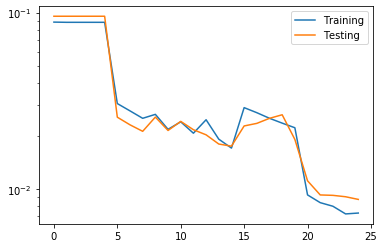

In [25]:
################################################################################
# %% PLOTTING LOSS CURVE
################################################################################

mp.semilogy(abs(np.array(acc)-1).flatten(), label='Training')
mp.semilogy(abs(np.array(val_acc)-1).flatten(), label='Testing')
#mp.semilogy(np.array(loss).flatten())
#mp.semilogy(np.array(val_loss).flatten())
mp.legend()
mp.show()

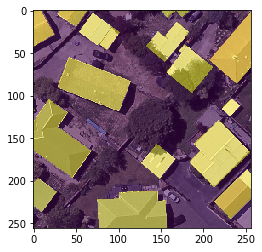

In [19]:
################################################################################
# %% PLOTTING BASE TRUTH
################################################################################

#X_test = np.load('drive/My Drive/Data/image-train-0.npy')
#y_test = np.load('drive/My Drive/Data/label-train-0.npy')

id = 63

mp.imshow(X_test[id,:,:,:])
mp.imshow(y_test[id,:,:,0], alpha=0.5)
mp.show()

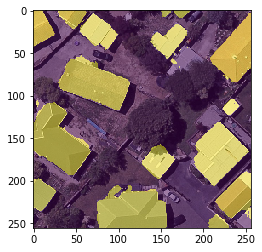

In [20]:
################################################################################
# %% PLOTTING PREDICTION ON TRAINING DATA
################################################################################

X_pred = X_test[id]
X_pred = X_pred[np.newaxis]
y_pred = model.predict(X_pred)

mp.imshow(X_pred[0])
mp.imshow(y_pred[0, :, :, 0]>0.5, alpha=0.5)
mp.show()